In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
import keras
import seaborn as sns
import h5py as h5py
from time import time
import sys
import matplotlib.pyplot as plt

sys.path.append("/Users/amir/code/keras-mdn-layer")
import mdn


# %load_ext autoreload
# %autoreload 2

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
data = np.load("../processed_data.npz")

In [3]:
# used for gym environment
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_test'])

In [4]:
data.files

['x_train', 'y_train', 'x_test', 'y_test']

In [5]:
data['x_train'].shape

(153582, 47)

In [6]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [7]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [8]:
train_matrix.shape

(153582, 10, 47)

In [9]:
test_matrix = get_padded_matrix( data['x_test'],  data['y_test'])

In [16]:
mixtures = 46
output_dim = train_matrix.shape[2]-1
model = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    keras.layers.Dense(128, activation='relu')
])
model.add(mdn.MDN(output_dim, mixtures))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
mdn_1 (MDN)                  (None, 4278)              551862    
Total params: 577,990
Trainable params: 577,990
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss=mdn.get_mixture_loss_func(output_dim, mixtures), optimizer=keras.optimizers.Adam())

In [18]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed_bayesian{}".format(time()))
cp_callback = keras.callbacks.ModelCheckpoint("sepsis_states_bayesian.model",
                                                 verbose=1, monitor='val_loss', save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_matrix, data['y_train'], validation_data=(test_matrix, data['y_test']), epochs=10, callbacks=[tensorboard, cp_callback, early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 153582 samples, validate on 39232 samples
Epoch 1/10
153582/153582 [==============================] - 127s 824us/step - loss: 9.2461 - val_loss: -15.0528

Epoch 00001: val_loss improved from inf to -15.05281, saving model to sepsis_states_bayesian.model
Epoch 2/10
153582/153582 [==============================] - 114s 742us/step - loss: -23.7375 - val_loss: -21.1841

Epoch 00002: val_loss improved from -15.05281 to -21.18409, saving model to sepsis_states_bayesian.model
Epoch 3/10
153582/153582 [==============================] - 113s 734us/step - loss: -33.9444 - val_loss: -37.8913

Epoch 00003: val_loss improved from -21.18409 to -37.89129, saving model to sepsis_states_bayesian.model
Epoch 4/10
153582/153582 [==============================] - 114s 740us/step - loss: -43.1849 - val_loss: -37.6862

Epoch 00004: val_loss did not improve from -37.89129
Epoch 5/10
153582/153582 [==============================] - 114s 742us/step - los

In [27]:
model = keras.models.load_model("sepsis_states_bayesian.model", compile=False, custom_objects={'MDN': mdn.MDN(output_dim, mixtures) })

In [41]:
test_predicted_dists = model.predict(test_matrix)

In [42]:
train_predicted_dists = model.predict(train_matrix)

In [43]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [44]:
test_predicted = np.apply_along_axis(mdn.sample_from_output, 1, test_predicted_dists, output_dim, mixtures, temp=1.0)


In [47]:
test_predicted = test_predicted.reshape((test_predicted.shape[0], test_predicted.shape[2]))

In [48]:
test_predicted_dists.shape

(39232, 4278)

In [50]:
test_predicted[0:11,columns.index('HeartRate')]

array([-0.47323237,  0.41384818,  0.71650044,  0.21742325, -1.04656197,
       -0.99061687, -1.38793709, -1.21058793, -1.21358426, -0.97441339,
       -2.54310745])

In [51]:
sns.set(style="white")

def plot(column, mode="test", prediction=test_predicted):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][6:24,columns.index(column)], label="truth", scaley=False)
    plt.plot(prediction[6:24,columns.index(column)], label="predicted", scaley=False)
    plt.ylim(-2, 2)
    plt.legend(["Real Value", "Predicted (No VAE)"])
    plt.title(column + " " + mode)
    plt.show()

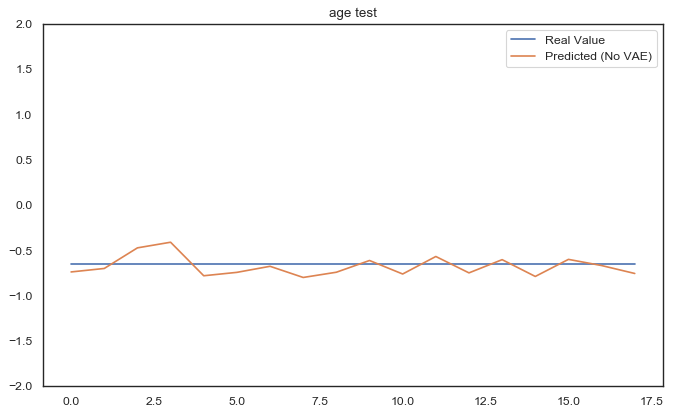

In [52]:
plot("age", "test", test_predicted)

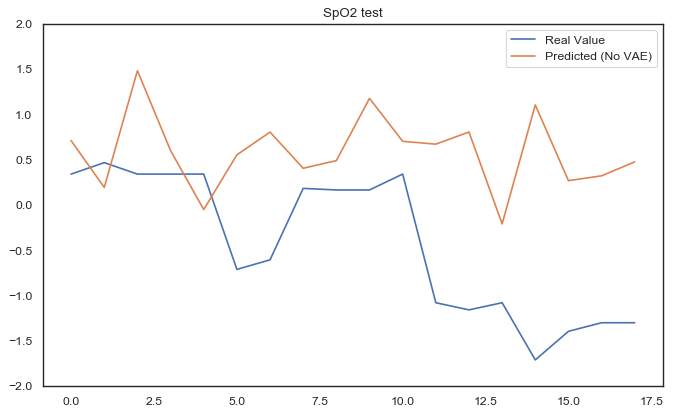

In [53]:
plot("SpO2", "test", test_predicted)

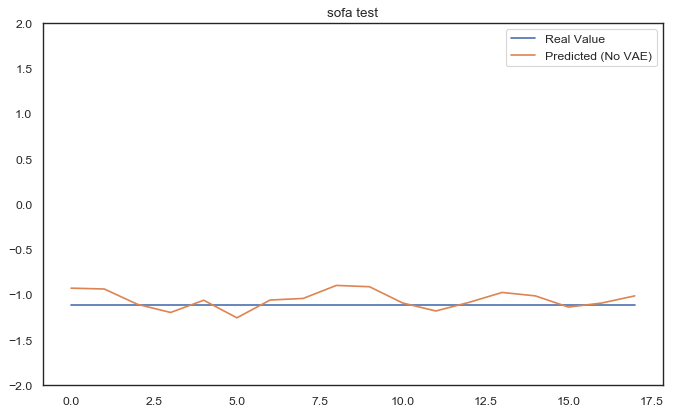

In [54]:
plot("sofa")

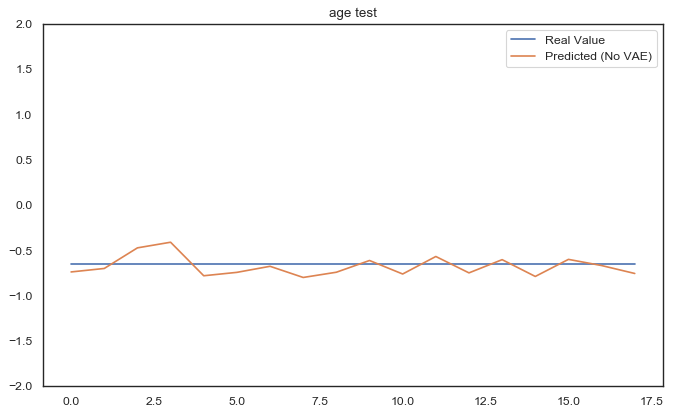

In [55]:
plot("age")

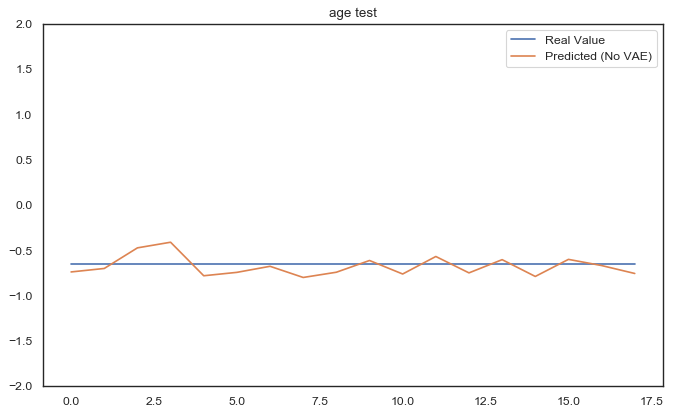

In [56]:
plot("age")

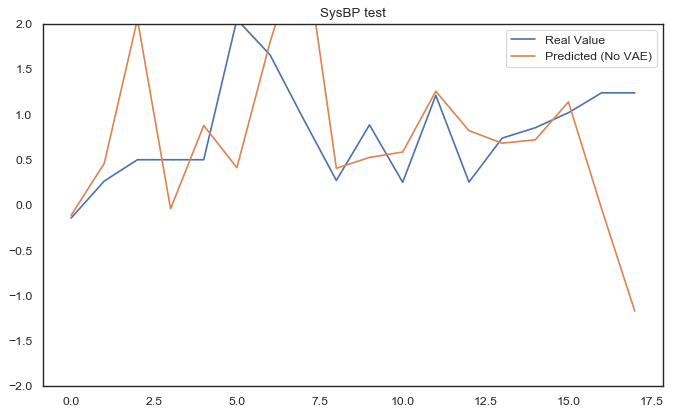

In [57]:
plot("SysBP")

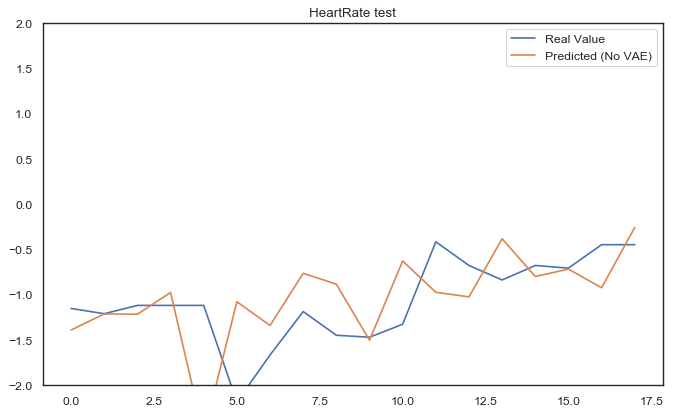

In [58]:
plot("HeartRate")

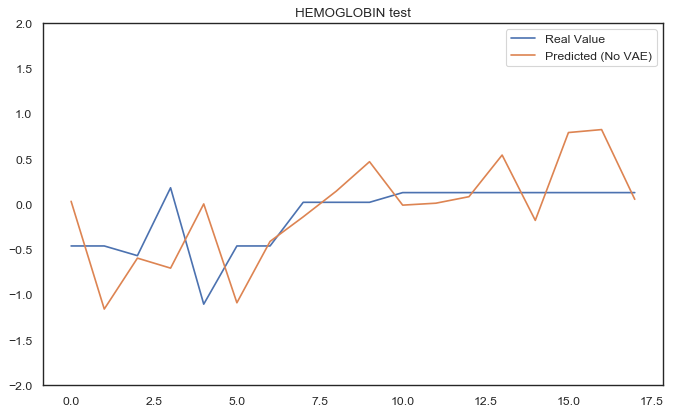

In [59]:
plot("HEMOGLOBIN")

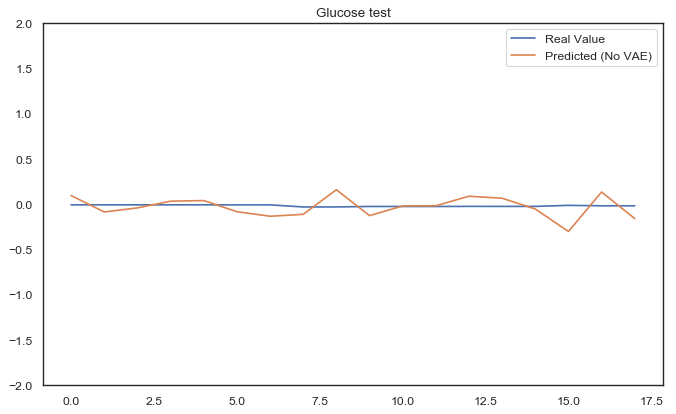

In [60]:
plot("Glucose")